[안진용] MobileNetV3를 사용하여 Grad-CAM시각화

# 라이브러리 임포트

In [30]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 이미지 전처리 함수

In [31]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # 배치 차원 추가 (shape: [1,])
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array) # MobileNetV3 전용 전처리 (픽셀 값 [-1, 1] 범위 정규화)

# Grad-CAM 히트맵 생성 함수

- GradientTape: 예측값에 대한 그라디언트 추적 시작
- conv_outputs: 마지막 컨볼루션 레이어의 출력 (특징 맵)
- oss: 타겟 클래스의 예측 확률
- grads: loss에 대한 conv_outputs의 그라디언트
- pooled_grads: 공간 차원(높이, 너비) 평균 → 채널별 중요도 가중치

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 컨볼루션 레이어와 출력값을 동시에 가져오는 모델 정의
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    
    # 그라디언트 계산
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 히트맵 계산
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap.numpy(), 0)
    heatmap /= np.max(heatmap) # 범위로 스케일링
    
    return heatmap

# 히트맵 오버레이 함수

In [33]:
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 원본 이미지를 RGB 형식으로 로드
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 빨강-파랑 컬러맵 적용
    superimposed_img = cv2.addWeighted(jet, alpha, img, 1 - alpha, 0) # addWeighted: 히트맵(jet)과 원본 이미지를 투명도(alpha)로 혼합
    
    return superimposed_img

# 메인 실행

## 원본이미지 히트맵 시각화

### 첫 번째 이미지
#### 원본 이미지

- 해파리가 바다 속에서 선명

- 배경(물, 해초 등)과 해파리의 경계가 뚜렷

#### 히트맵

- 모델이 해파리의 몸통과 촉수 부분에 집중하고 있음

- 노란색과 초록색 부분이 모델이 중요하다고 판단한거 같다.

#### 오버레이 결과

- 모델이 해파리의 주요 부분을 잘 인식했음을 알 수 있다.

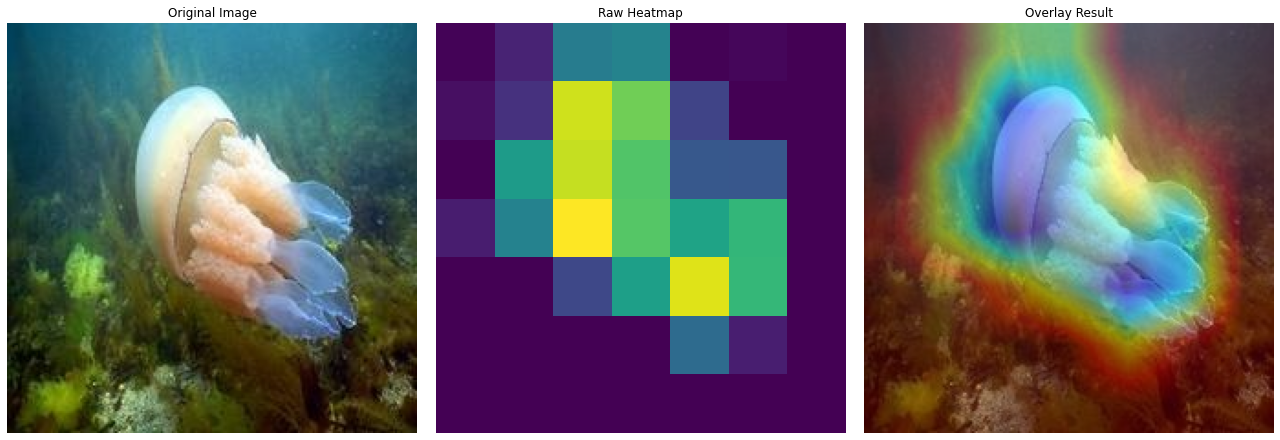

In [34]:
if __name__ == "__main__":
    # MobileNetV3 모델 로드
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        weights="imagenet",
        include_top=True
    )
    
    # Grad-CAM을 적용할 레이어 지정
    last_conv_layer_name = "Conv_1"
    
    # 이미지 경로 설정
    img_path = "/aiffel/aiffel/jellyfish/barrel_jellyfish/01.jpeg"
    
    # 1. 원본 이미지 로드 및 전처리
    img_array = preprocess_image(img_path)  # 모델 입력용 전처리된 이미지
    
    # 2. 히트맵 생성
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # 3. 시각화를 위한 원본 이미지 별도 로드 (전처리 없음)
    original_img = tf.io.read_file(img_path)
    original_img = tf.image.decode_png(original_img, channels=3)
    original_img = tf.image.resize(original_img, [224, 224])  # 리사이즈만 수행
    original_img = original_img.numpy().astype("uint8")  # [0-255] 범위 유지
    
    # 4. 히트맵 오버레이 생성
    superimposed_img = overlay_heatmap(heatmap, img_path)

    # 5. 3개의 서브플롯으로 시각화
    plt.figure(figsize=(18, 6))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    # 순수 히트맵
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')  # 컬러맵으로 히트맵 시각화
    plt.title("Raw Heatmap")
    plt.axis('off')
    
    # 합성 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## 원본이미지 배경제거 전처리 후 히트맵 시각화

### 두 번째 이미지
#### 원본 이미지 

- 배경이 제거된 상태 해파리 주변이 흐릿하게 보임

- 배경 제거 과정에서 경계가 부드럽게 처리되면서 전체적으로 뿌연 느낌

#### 히트맵

- 첫 번째 이미지와 동일하게 모델이 해파리의 몸통과 촉수에 집중하는거 같다.

#### 오버레이 결과

- 원본 이미지가 뿌옇기 때문에 히트맵도 덜 선명하게 보입니다.

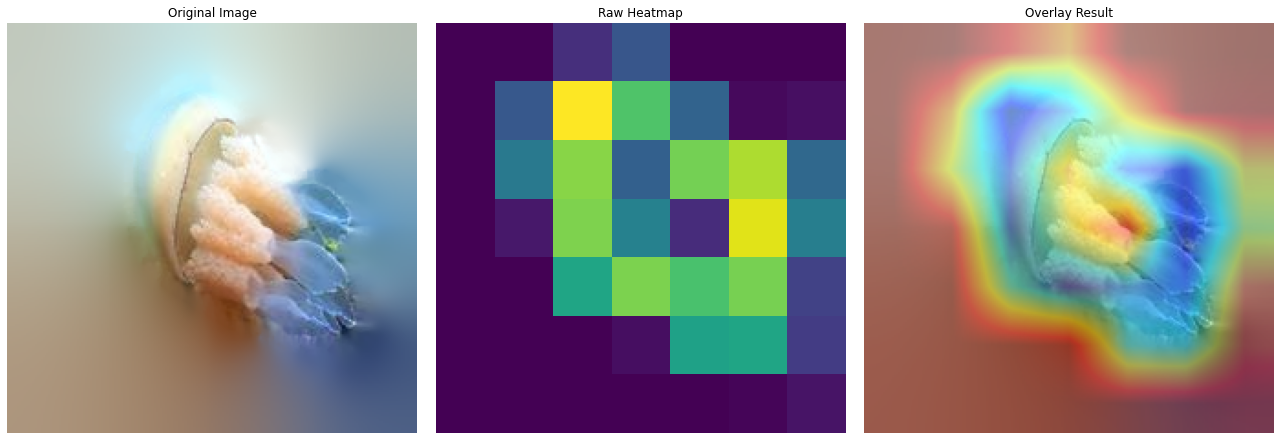

In [35]:
if __name__ == "__main__":
    # MobileNetV3 모델 로드
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        weights="imagenet",
        include_top=True
    )
    
    # Grad-CAM을 적용할 레이어 지정
    last_conv_layer_name = "Conv_1"
    
    # 이미지 경로 설정
    img_path = "/aiffel/aiffel/jellyfish/jellyfish_background_remove/barrel_jellyfish_output_again/01.jpg"
    
    # 1. 원본 이미지 로드 및 전처리
    img_array = preprocess_image(img_path)  # 모델 입력용 전처리된 이미지
    
    # 2. 히트맵 생성
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # 3. 시각화를 위한 원본 이미지 별도 로드 
    original_img = tf.io.read_file(img_path)
    original_img = tf.image.decode_png(original_img, channels=3)
    original_img = tf.image.resize(original_img, [224, 224])  # 리사이즈만 수행
    original_img = original_img.numpy().astype("uint8")  # [0-255] 범위 유지
    
    # 4. 히트맵 오버레이 생성
    superimposed_img = overlay_heatmap(heatmap, img_path)

    # 5. 3개의 서브플롯으로 시각화
    plt.figure(figsize=(18, 6))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    # 순수 히트맵
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')  # 컬러맵으로 히트맵 시각화
    plt.title("Raw Heatmap")
    plt.axis('off')
    
    # 합성 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
